In [213]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math

data = pd.read_csv('PUBGdata_rå.csv', delimiter=";")
data['kills_per_mand'] = data['kills_total']/data['antal_spillere']

data['CD_kills'] = [
    data['kills_per_mand'] if i==1
    else 0
    for i in data['plads']
]

gennemsnit = data.groupby('dag').agg(
    Average_Kills_Per_Mand = ('kills_per_mand','mean'),
    Antal_spil = ('spil',max)
)


data['dailyavg'] = [
    gennemsnit['Average_Kills_Per_Mand'][1] if i==1
    else gennemsnit['Average_Kills_Per_Mand'][2] if i==2
    else gennemsnit['Average_Kills_Per_Mand'][3] if i==3
    else gennemsnit['Average_Kills_Per_Mand'][4] if i==4
    else gennemsnit['Average_Kills_Per_Mand'][5] if i==5
    else gennemsnit['Average_Kills_Per_Mand'][6] if i==6
    else gennemsnit['Average_Kills_Per_Mand'][7] if i==7
    else gennemsnit['Average_Kills_Per_Mand'][8] if i==8
    else gennemsnit['Average_Kills_Per_Mand'][9] if i==9
    else gennemsnit['Average_Kills_Per_Mand'][10] if i==10
    else 0
    for i in data['dag']
]

data


,spil,kills_total,antal_spillere,plads,dag,ekstra_spiller,kills_per_mand,CD_kills,dailyavg
0,1,2,2,0,1,0,1.000000,0,0.857143
1,2,0,2,0,1,0,0.000000,0,0.857143
2,3,2,2,0,1,0,1.000000,0,0.857143
3,4,3,2,0,1,0,1.500000,0,0.857143
4,5,0,2,0,1,0,0.000000,0,0.857143
...,...,...,...,...,...,...,...,...,...
196,197,5,3,0,9,kenneth,1.666667,0,1.453333
197,198,3,3,0,9,kenneth,1.000000,0,1.453333
198,199,6,3,0,9,kenneth,2.000000,0,1.453333
199,200,2,3,0,9,kenneth,0.666667,0,1.453333


<function matplotlib.pyplot.show(*args, **kw)>

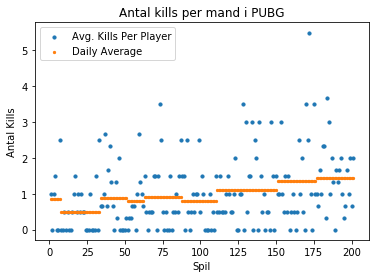

In [216]:
plt.scatter(data['spil'],data['kills_per_mand'], s=10, label='Avg. Kills Per Player')
plt.scatter(data['spil'],data['dailyavg'], s=5, label='Daily Average')
plt.xlabel('Spil')
plt.ylabel('Antal Kills')
plt.title('Antal kills per mand i PUBG')
plt.legend(loc='upper left')
plt.savefig('Own.pdf')
plt.show













In [171]:
print(data['kills_per_mand'])

0      1.000000
1      0.000000
2      1.000000
3      1.500000
4      0.000000
         ...   
196    1.666667
197    1.000000
198    2.000000
199    0.666667
200    2.000000
Name: kills_per_mand, Length: 201, dtype: float64
